### Fault Detection and Classification Scheme for Distribution Lines Using Machine Learning

The code demonstrates the application of machine learning models for fault detection and classification in power systems. The use of Random Forest Classifier proves effective for both binary and multiclass classification tasks. Class-wise error analysis provides valuable insights for model improvement.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [33]:
# Set the plotting style to 'darkgrid' using Seaborn
sns.set_style('darkgrid')

# Set the default figure size for matplotlib plots to 13x9 inches
plt.rcParams['figure.figsize'] = (13, 9)

# Set the default font size for matplotlib plots to 20
plt.rcParams['font.size'] = 20

# Ignore warnings during the execution of the code
warnings.filterwarnings('ignore')

For Multiclass Classification
Output: [G C B A]

[0 0 0 0] - No Fault
[1 0 0 1] - LG fault (Between Phase A and Ground)
[0 0 1 1] - LL fault (Between Phase A and Phase B)
[1 0 1 1] - LLG Fault (Between Phases A,B and Ground)
[0 1 1 1] - LLL Fault (Between all three phases)
[1 1 1 1] - LLLG fault (Three phase symmetrical fault)

In [34]:
# Reading binary data from 'detect_dataset.csv' into a DataFrame named 'binary_data'
binary_data = pd.read_csv('detect_dataset.csv')

# Reading multi-class data from 'classData.csv' into a DataFrame named 'multi_data'
multi_data = pd.read_csv('classData.csv')

# Check if there are any missing values in the 'binary_data' DataFrame
# by creating a boolean mask where True represents missing values (NaN),
# and then checking if the sum of missing values is greater than 0 in any column.
any(binary_data.isna().sum() > 0)

True

In [35]:
# Display concise summary information about the 'multi_data' DataFrame
multi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7861 entries, 0 to 7860
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G       7861 non-null   int64  
 1   C       7861 non-null   int64  
 2   B       7861 non-null   int64  
 3   A       7861 non-null   int64  
 4   Ia      7861 non-null   float64
 5   Ib      7861 non-null   float64
 6   Ic      7861 non-null   float64
 7   Va      7861 non-null   float64
 8   Vb      7861 non-null   float64
 9   Vc      7861 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 614.3 KB


In [36]:
# Display the first few rows of the 'multi_data' DataFrame
multi_data.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


In [37]:
# Check if there are any missing values in the 'multi_data' DataFrame
any_missing_values = any(multi_data.isna().sum() > 0)

False

Binary Classification - Fault Detection

In [38]:
# Drop columns at indices 7 and 8 from the 'binary_data' DataFrame along the columns (axis=1)
binary_data.drop(binary_data.iloc[:, [7, 8]], axis=1, inplace=True)

In [39]:
print(f'Number of Samples: {binary_data.shape[0]} \n Number of Features: {binary_data.shape[1]}')

Number of Samples: 12001 
 Number of Features: 7


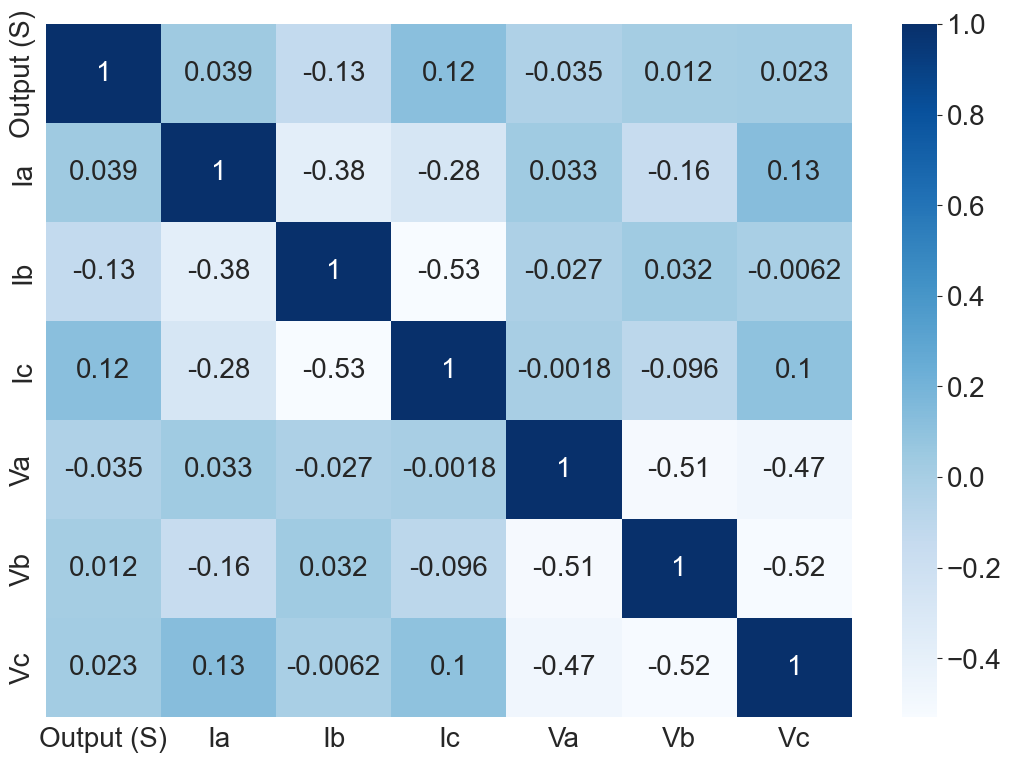

In [40]:
# Create a heatmap to visualize the correlation matrix of the 'binary_data' DataFrame
# 'annot=True' displays the correlation values in the heatmap
# 'cmap='Blues'' sets the color map to shades of blue
sns.heatmap(binary_data.corr(), annot=True, cmap='Blues')

# Display the plot
plt.show()


Voltage vs Current

Text(0, 0.5, 'Vc')

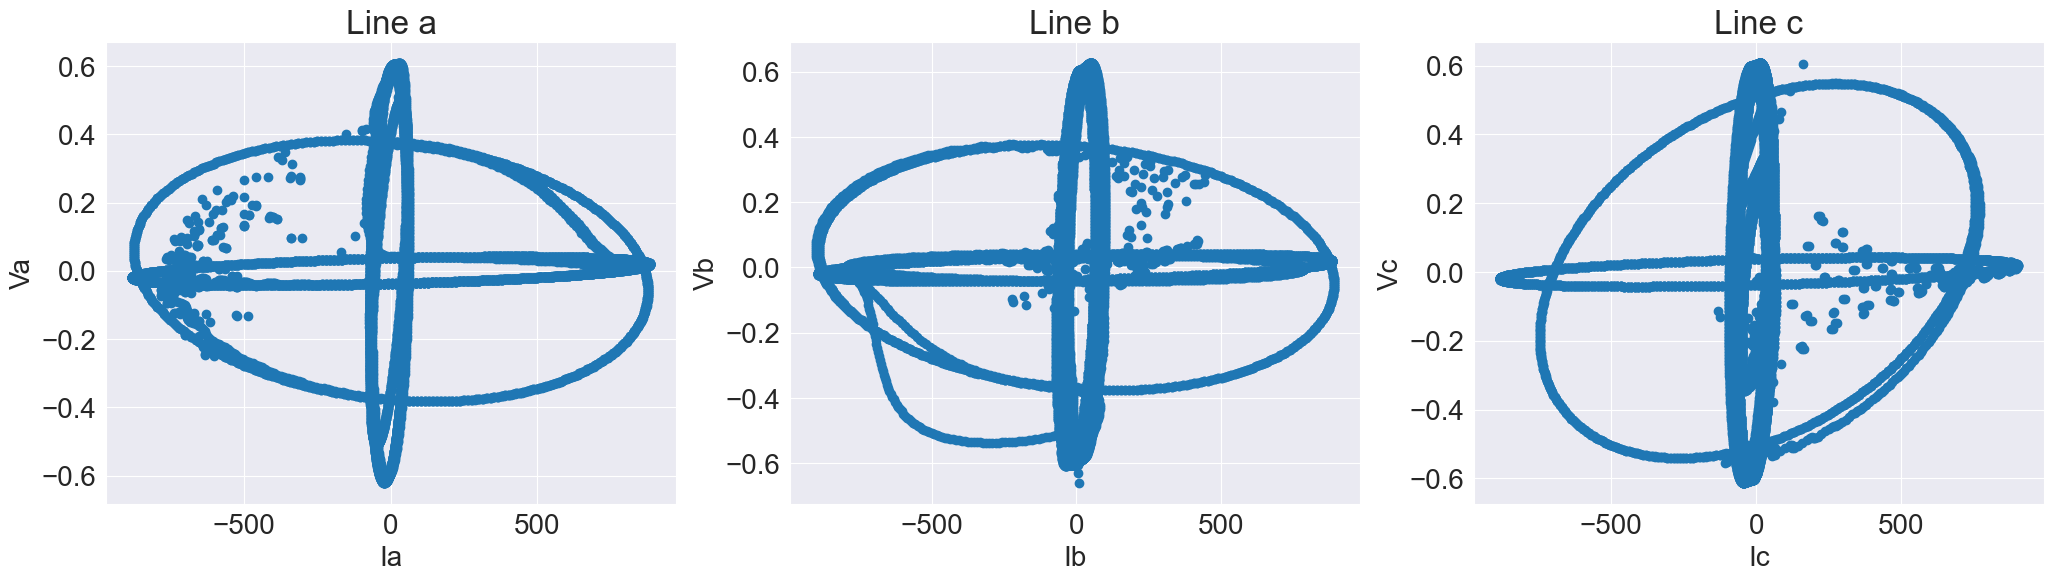

In [41]:
# Create a figure with a 1x3 grid of subplots
plt.figure(figsize=(25, 6))

# Subplot 1
a1 = plt.subplot2grid((1, 3), (0, 0))
a1.scatter(binary_data['Ia'], binary_data['Va'])
a1.set_title('Line a')
a1.set_xlabel('Ia')
a1.set_ylabel('Va')

# Subplot 2
a2 = plt.subplot2grid((1, 3), (0, 1))
a2.scatter(binary_data['Ib'], binary_data['Vb'])
a2.set_title('Line b')
a2.set_xlabel('Ib')
a2.set_ylabel('Vb')

# Subplot 3
a3 = plt.subplot2grid((1, 3), (0, 2))
a3.scatter(binary_data['Ic'], binary_data['Vc'])
a3.set_title('Line c')
a3.set_xlabel('Ic')
a3.set_ylabel('Vc')

# Display the plot
plt.show()


Composition of Target variable


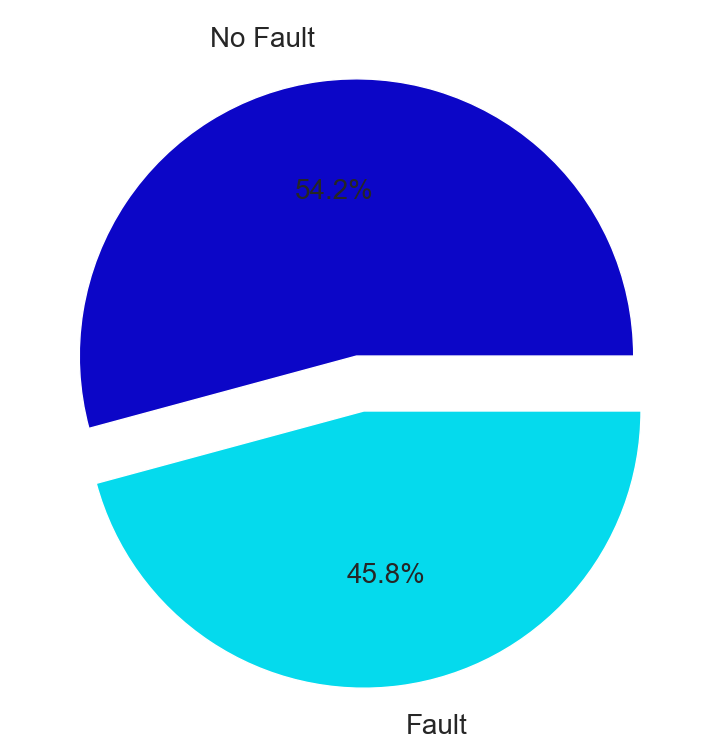

In [42]:
# Create a pie chart to visualize the distribution of 'Output (S)' in 'binary_data'
plt.pie(x=binary_data['Output (S)'].value_counts(), labels=['No Fault', 'Fault'],
        explode=[0, 0.2], autopct='%1.1f%%', labeldistance=1.15,
        colors=['#0c06c7', '#05daed'])

# Display the plot
plt.show()


In [43]:
def dist(cola, colb):
    """
    Plot distribution plots for two columns in the 'binary_data' DataFrame.

    Parameters:
    - cola: Column name for Line Current
    - colb: Column name for Line Voltage

    Returns:
    - Two subplots displaying distribution plots for the specified columns.
    """
    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 10))

    # Plot distribution of Line Current in the first subplot
    sns.distplot(binary_data[cola], label='Line Current', hist=True, color='#fc0328', ax=axs[0])

    # Plot distribution of Line Voltage in the second subplot
    sns.distplot(binary_data[colb], label='Line Voltage', hist=True, color='#0c06c7', ax=axs[1])

    # Add legends to both subplots
    axs[0].legend(loc='upper right', prop={'size': 12})
    axs[1].legend(loc='upper right', prop={'size': 12})

    # Display the plot
    plt.show()


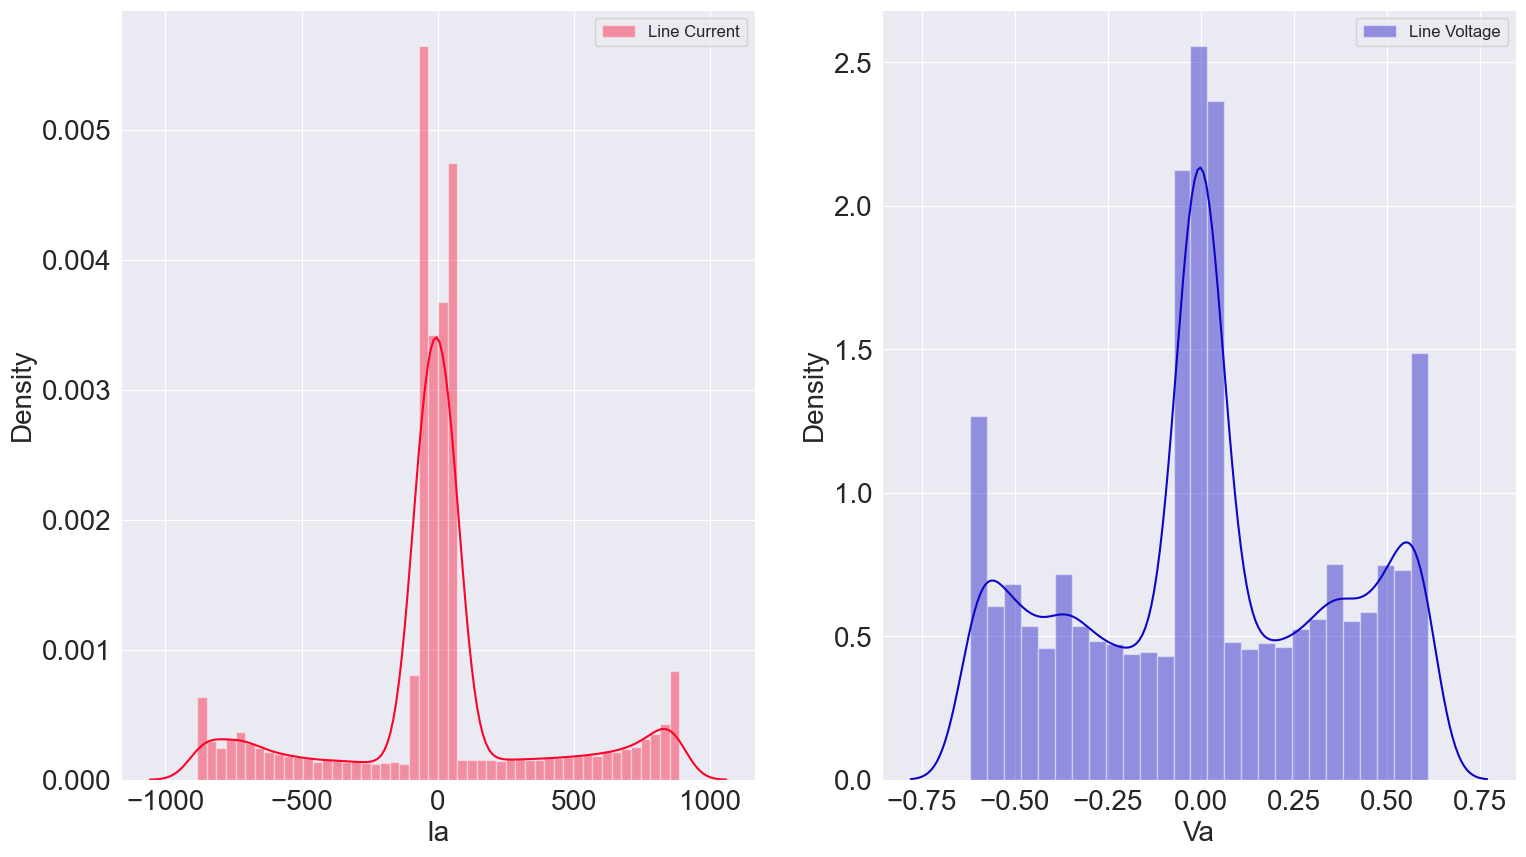

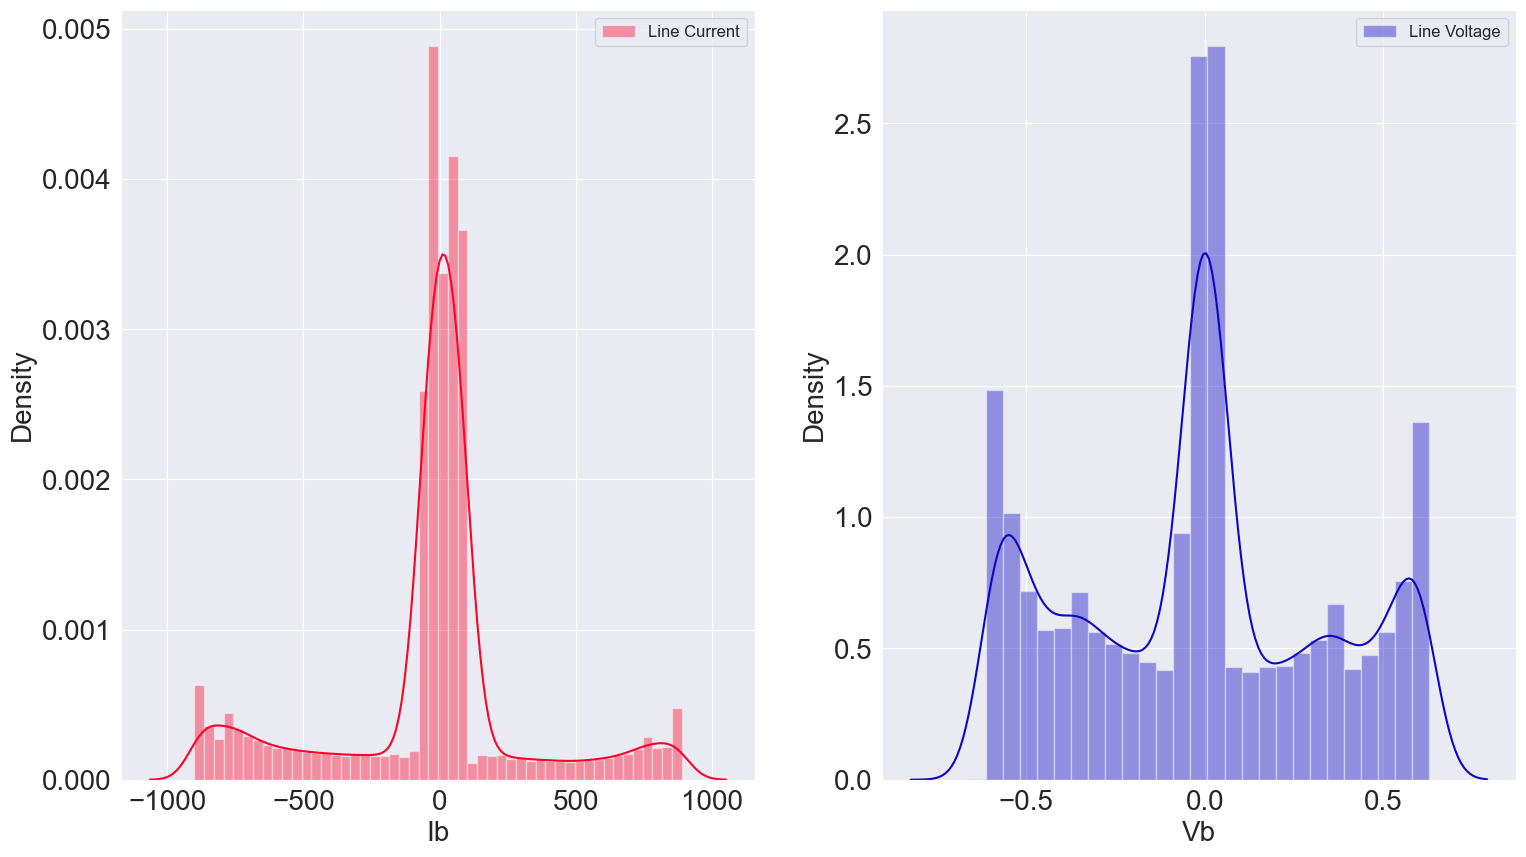

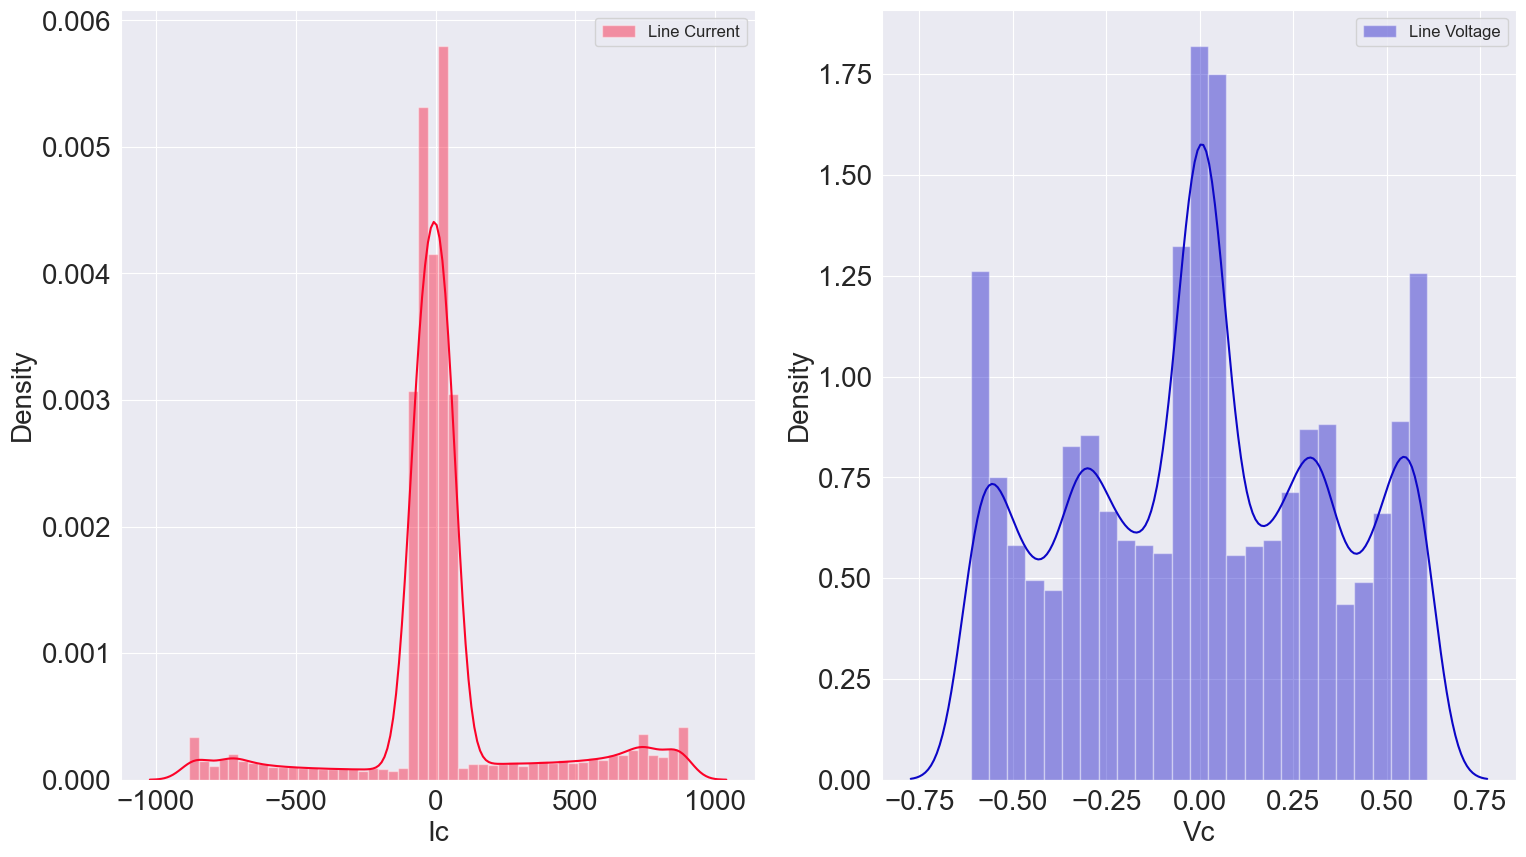

In [44]:
# Define pairs of columns representing lines
lines = [
    ('Ia', 'Va'),
    ('Ib', 'Vb'),
    ('Ic', 'Vc')
]

# Iterate through the lines and plot distribution plots for each pair of columns
for cola, colb in lines:
    dist(cola, colb)
    print('\n')


Model Building - Binary Classifier


In [45]:
# Selecting the target variable 'y' and features 'X' from the 'binary_data' DataFrame
y = binary_data.iloc[:, 0]
X = binary_data.iloc[:, 1:7]

# Split the data into training and testing sets using a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Display the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((9600, 6), (2401, 6), (9600,), (2401,))

In [46]:
# Create a RandomForestClassifier model
model_1 = RandomForestClassifier()

# Train the model using the training data
model_1.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_1.predict(X_test)


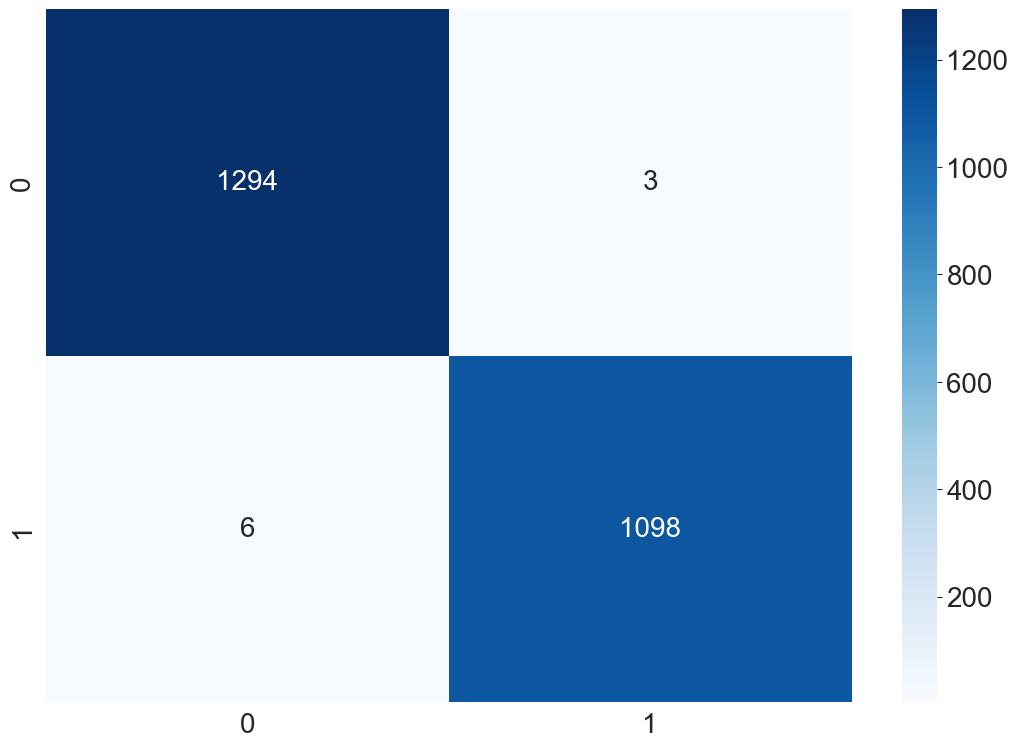

In [47]:
# Create a heatmap of the confusion matrix for model predictions
# 'annot=True' displays the values inside the heatmap cells
# 'cmap='Blues'' sets the color map to shades of blue
# 'fmt='.4g'' formats the annotation values to 4 significant figures
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='.4g')

# Display the plot
plt.show()


In [48]:
# Print accuracy, precision, and recall scores for the model's predictions on the test set
print(f'Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.03f}%')
print(f'Precision Score: {precision_score(y_test, y_pred) * 100:.03f}%')
print(f'Recall Score: {recall_score(y_test, y_pred) * 100:.03f}%')


Accuracy Score: 99.625%
Precision Score: 99.728%
Recall Score: 99.457%


In [49]:
# Print the classification report for the model's predictions on the test set
print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1297
           1       1.00      0.99      1.00      1104

    accuracy                           1.00      2401
   macro avg       1.00      1.00      1.00      2401
weighted avg       1.00      1.00      1.00      2401



Multiclass Classification


In [50]:
# Print the number of samples and features in the 'multi_data' DataFrame
print(f'Number of Samples: {multi_data.shape[0]}\nNumber of Features: {multi_data.shape[1]}')


Number of Samples: 7861
Number of Features: 10


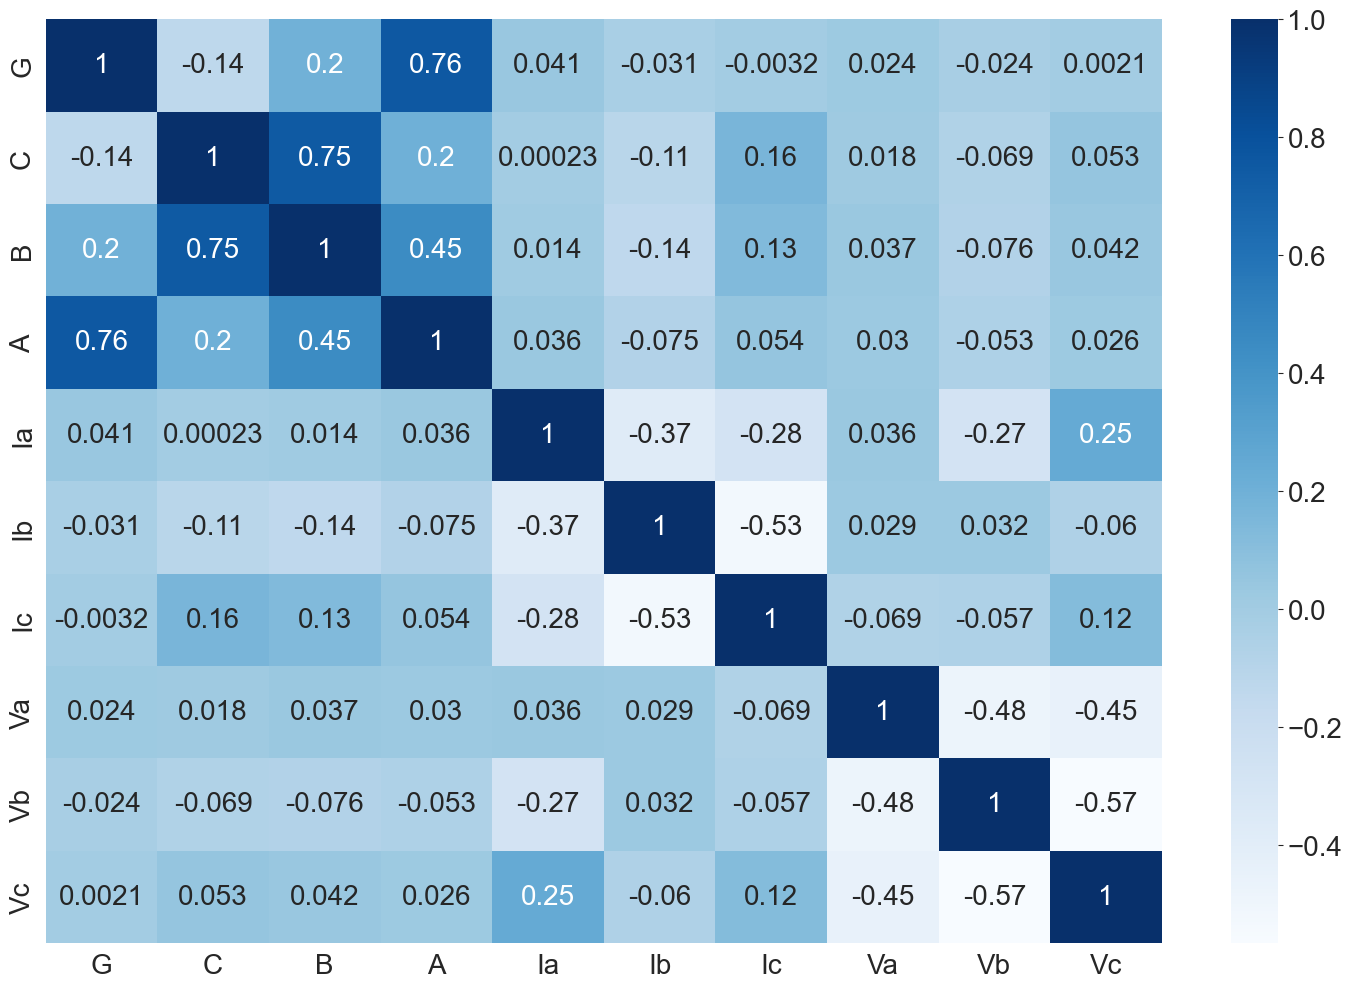

In [66]:
# Create a heatmap to visualize the correlation matrix of the 'multi_data' DataFrame
# 'annot=True' displays the correlation values in the heatmap
# 'cmap='Blues'' sets the color map to shades of blue
plt.figure(figsize=(18, 12))
sns.heatmap(multi_data.corr(), annot=True, cmap='Blues')

# Display the plot
plt.show()


Voltage vs Current

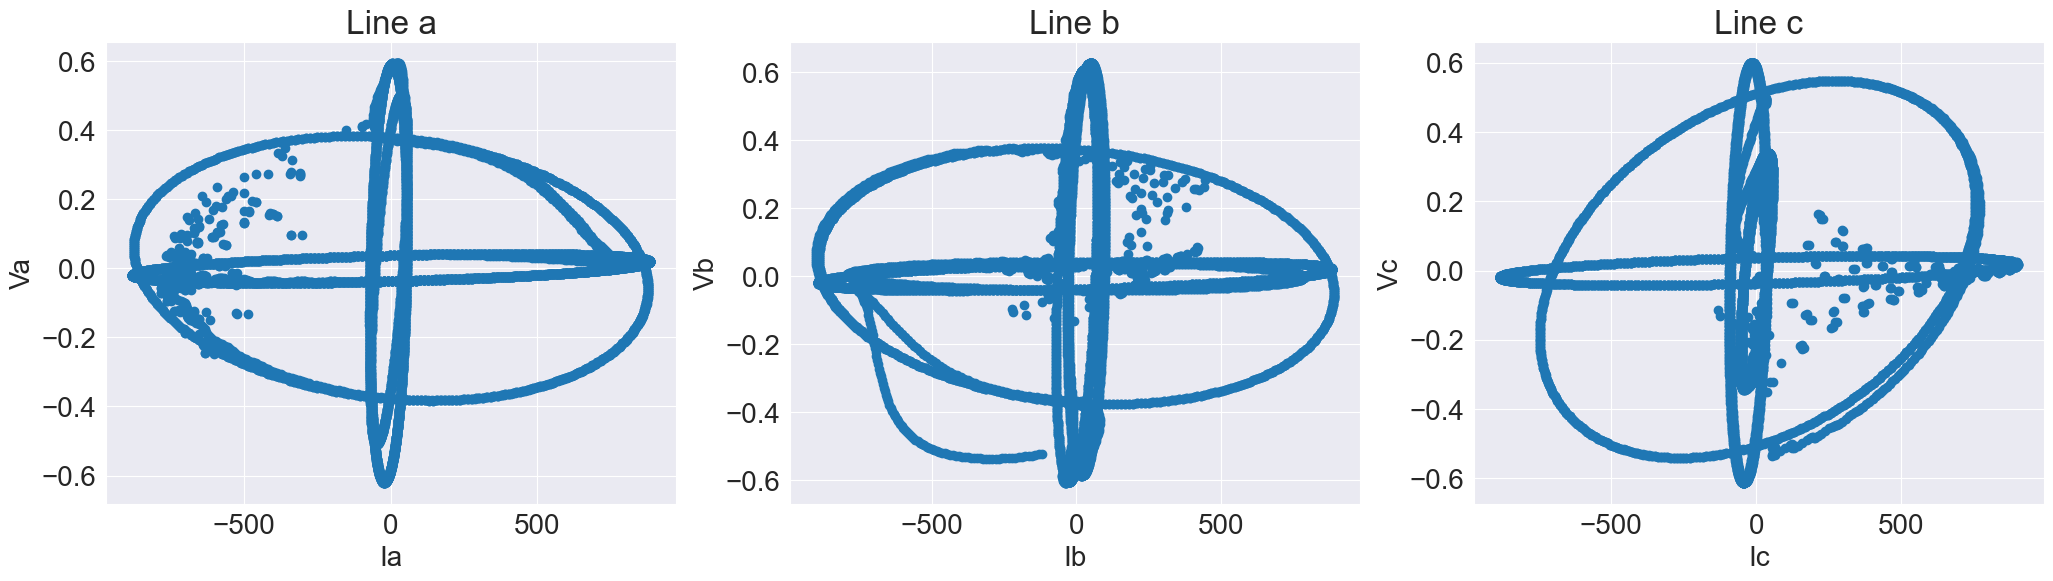

In [52]:
# Create a figure with a 1x3 grid of subplots
plt.figure(figsize=(25, 6))

# Subplot 1
a1 = plt.subplot2grid((1, 3), (0, 0))
a1.scatter(multi_data['Ia'], multi_data['Va'])
a1.set_title('Line a')
a1.set_xlabel('Ia')
a1.set_ylabel('Va')

# Subplot 2
a2 = plt.subplot2grid((1, 3), (0, 1))
a2.scatter(multi_data['Ib'], multi_data['Vb'])
a2.set_title('Line b')
a2.set_xlabel('Ib')
a2.set_ylabel('Vb')

# Subplot 3
a3 = plt.subplot2grid((1, 3), (0, 2))
a3.scatter(multi_data['Ic'], multi_data['Vc'])
a3.set_title('Line c')
a3.set_xlabel('Ic')
a3.set_ylabel('Vc')

# Display the plot
plt.show()


In [53]:
def dist(cola, colb):
    """
    Plot distribution plots for two columns in the 'multi_data' DataFrame.

    Parameters:
    - cola: Column name for Line Current
    - colb: Column name for Line Voltage

    Returns:
    - Two subplots displaying distribution plots for the specified columns.
    """
    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(18, 10))

    # Plot distribution of Line Current in the first subplot
    sns.distplot(multi_data[cola], label='Line Current', hist=True, color='#fc0328', ax=axs[0])

    # Plot distribution of Line Voltage in the second subplot
    sns.distplot(multi_data[colb], label='Line Voltage', hist=True, color='#0c06c7', ax=axs[1])

    # Add legends to both subplots
    axs[0].legend(loc='upper right', prop={'size': 12})
    axs[1].legend(loc='upper right', prop={'size': 12})

    # Display the plot
    plt.show()


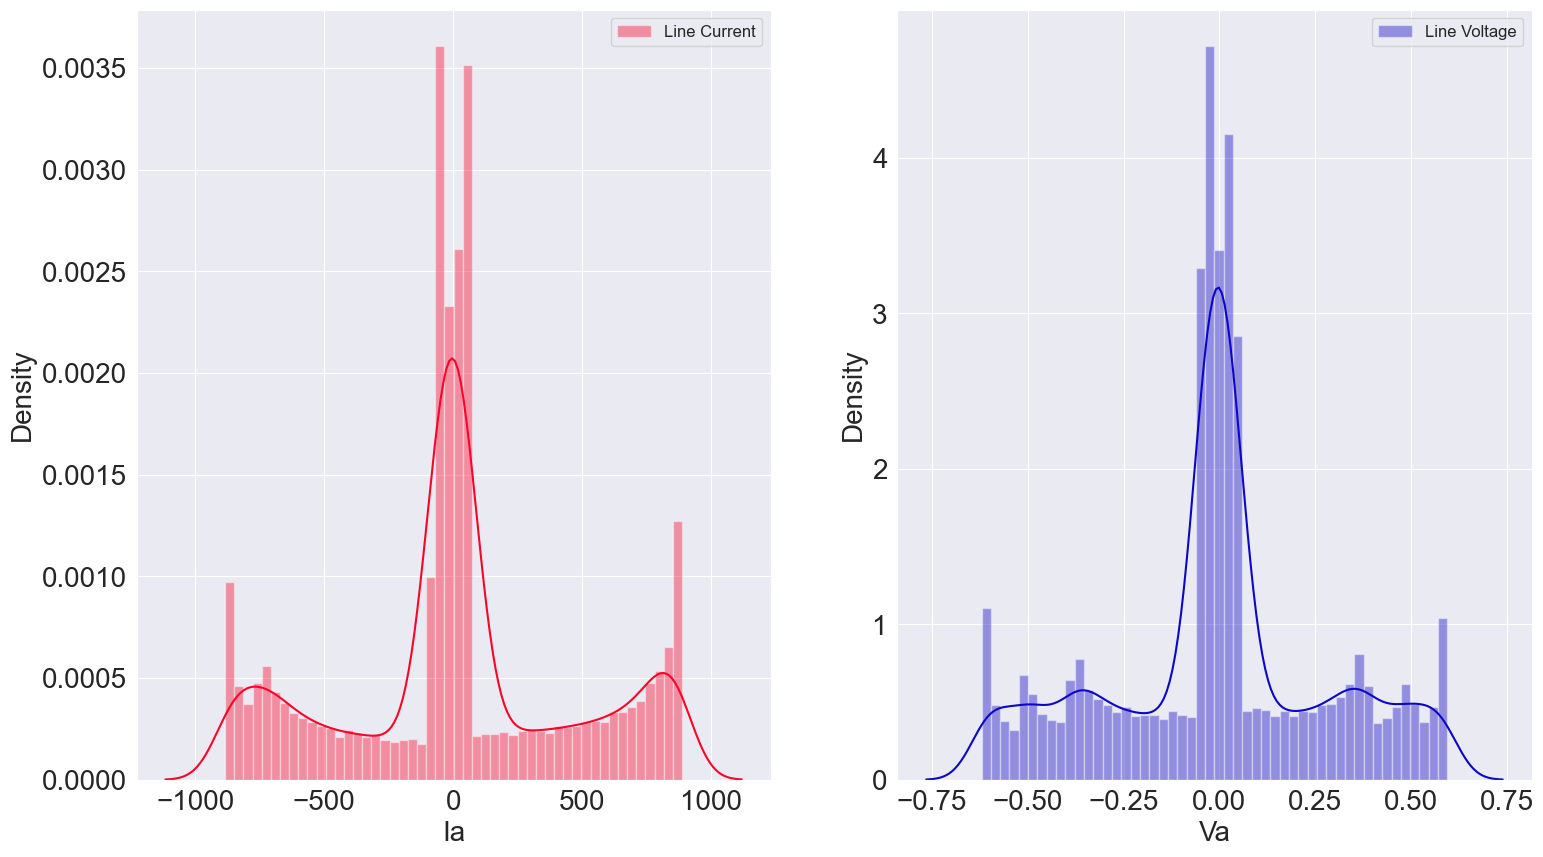

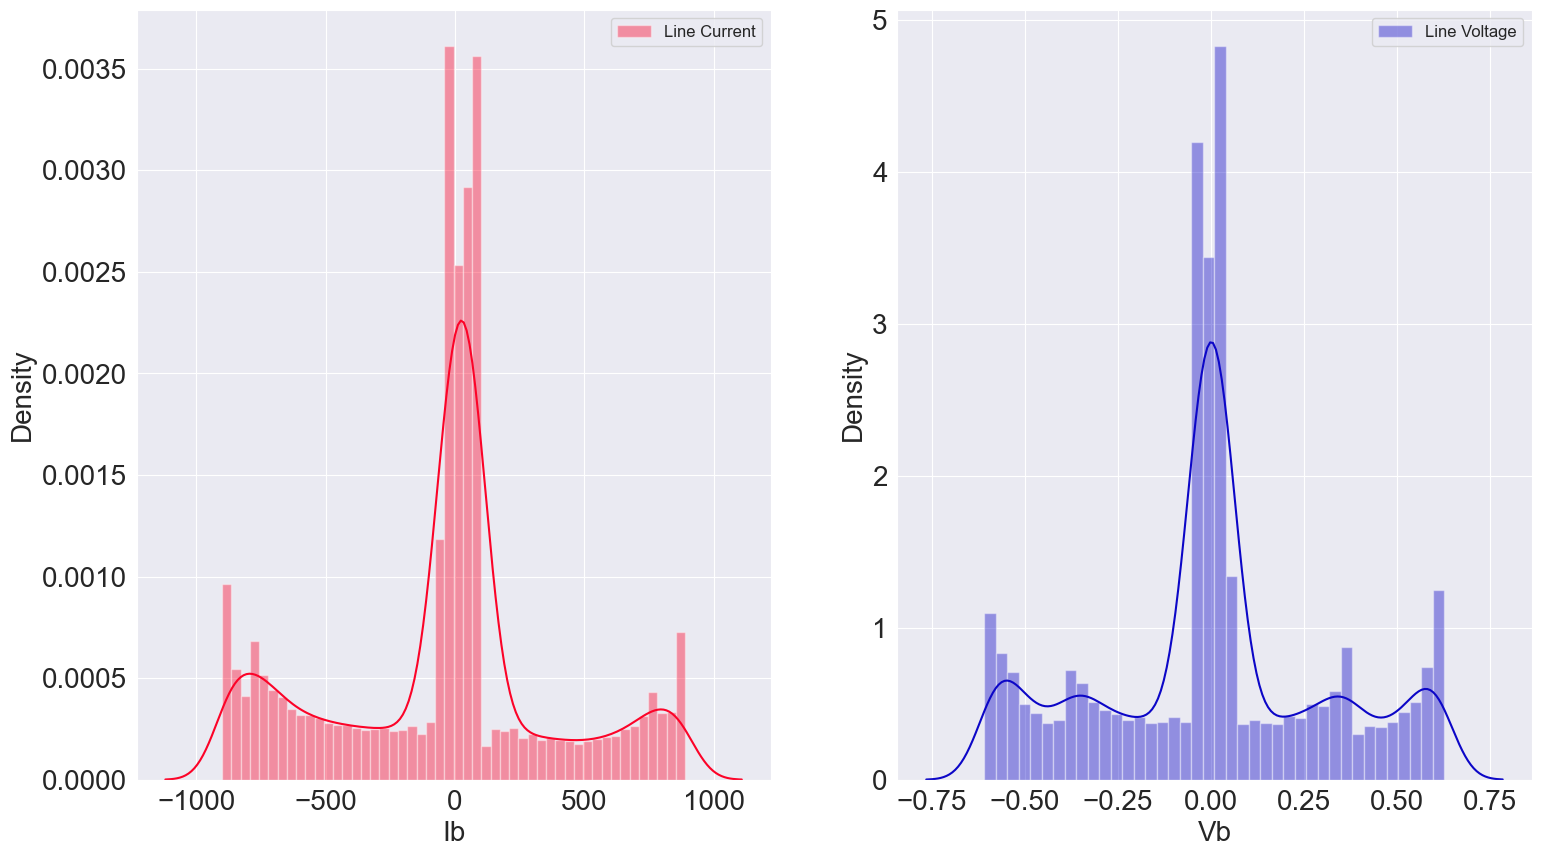

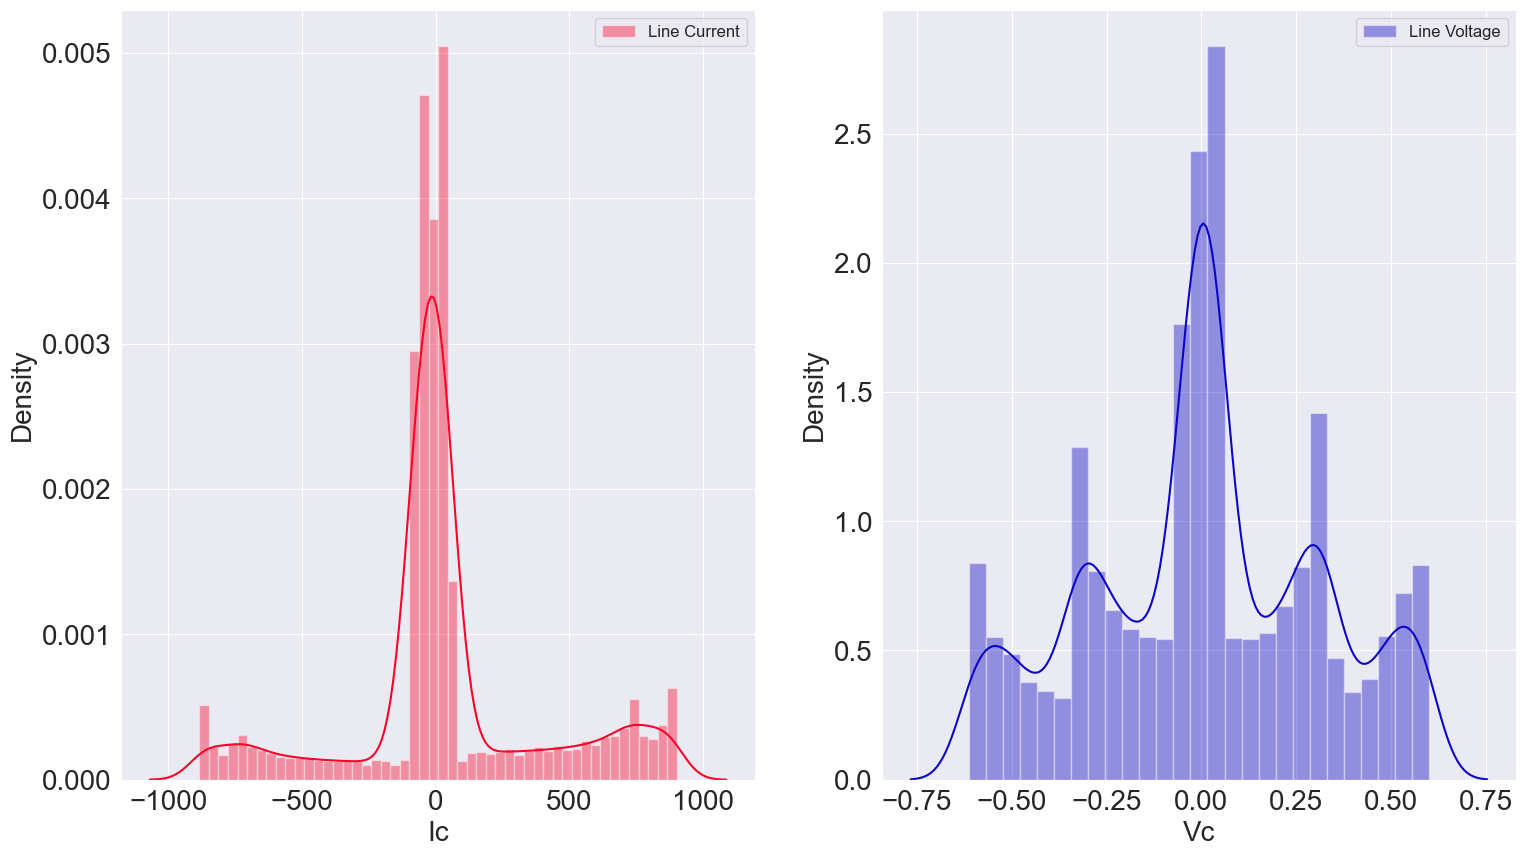

In [54]:
# Iterate through the lines and plot distribution plots for each pair of columns
for cola, colb in lines:
    dist(cola, colb)
    print('\n')


Model Building - Multiclass Classifier


In [55]:
# Combine columns 'G', 'C', 'B', and 'A' to create a new 'faultType' column
multi_data['faultType'] = multi_data['G'].astype(str) + multi_data['C'].astype(str) + multi_data['B'].astype(str) + multi_data['A'].astype(str)

# Display the first few rows of the updated 'multi_data' DataFrame
multi_data.head()


,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,faultType
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001


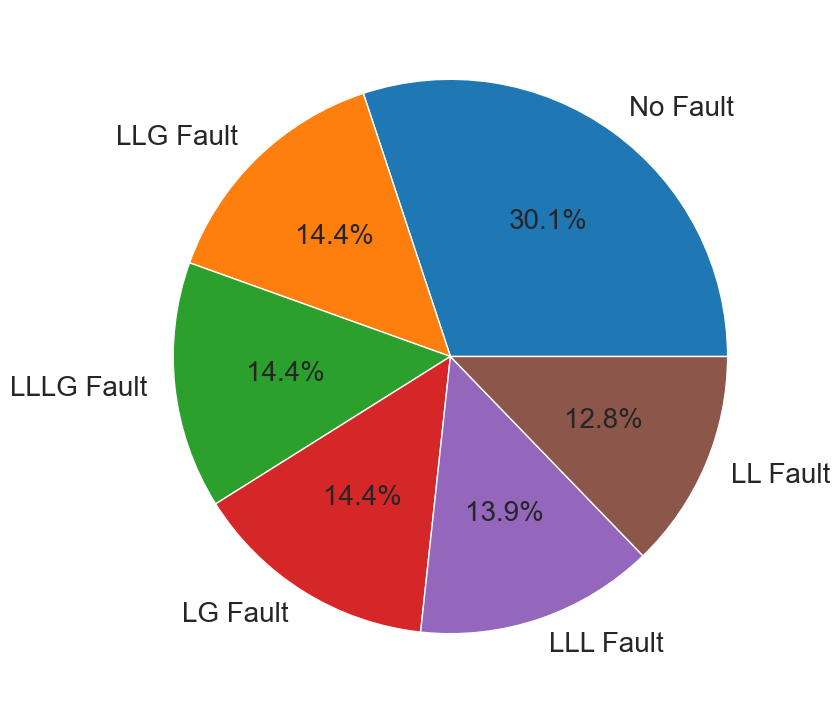

In [56]:
# Create a pie chart to visualize the distribution of 'faultType' in 'multi_data'
plt.pie(multi_data['faultType'].value_counts(), autopct='%1.1f%%',
        labels=['No Fault', 'LLG Fault', 'LLLG Fault', 'LG Fault', 'LLL Fault', 'LL Fault'])

# Display the plot
plt.show()


In [57]:
# Separate features and target variable in the 'multi_data' DataFrame
X = multi_data.drop(['G', 'C', 'B', 'A', 'faultType'], axis=1)
y = multi_data['faultType']

# Label encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

# Split the data into training and testing sets using a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

# Display the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6288, 6), (1573, 6), (6288,), (1573,))

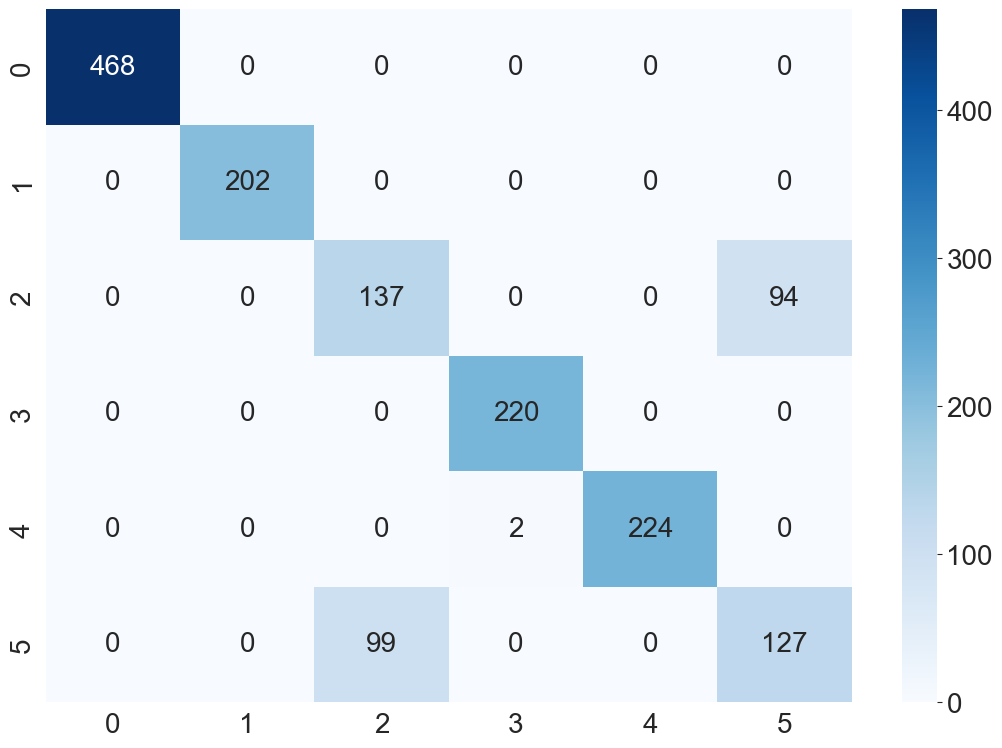

In [67]:
# Create a RandomForestClassifier model
model_2 = RandomForestClassifier()

# Train the model using the training data
model_2.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_2.predict(X_test)

# Create a heatmap of the confusion matrix for model predictions
# 'annot=True' displays the values inside the heatmap cells
# 'cmap='Blues'' sets the color map to shades of blue
# 'fmt='.4g'' formats the annotation values to 4 significant figures
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='.4g')

# Display the plot
plt.show()

In [59]:
# Print the accuracy score for the model's predictions on the test set
print(f'Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.03f}%')


Accuracy Score: 87.413%


In [60]:
# Print the classification report for the model's predictions on the test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       468
           1       1.00      1.00      1.00       202
           2       0.57      0.60      0.58       231
           3       0.99      1.00      1.00       220
           4       1.00      0.99      1.00       226
           5       0.57      0.54      0.56       226

    accuracy                           0.87      1573
   macro avg       0.86      0.86      0.86      1573
weighted avg       0.87      0.87      0.87      1573



# Class-wise Error Analysis
Class-wise error analysis is a method used to evaluate the performance of a machine learning classifier in multiclass classification tasks. It involves computing different metrics for each class separately, rather than aggregating them across all classes as in overall accuracy. The main advantage of class-wise error analysis is that it provides a more detailed understanding of the strengths and weaknesses of the classifier for each class, which can help in identifying areas for improvement.

By computing metrics such as accuracy and F1-score for each class, we can identify which classes are being misclassified the most and which ones are being classified correctly. This information can be used to fine-tune the classifier and improve its performance.

In [61]:
# Generate a classification report with output in dictionary format
cr = classification_report(y_test, y_pred, output_dict=True)

# Extract and display the keys from the classification report dictionary
cr_keys = cr.keys()

dict_keys(['0', '1', '2', '3', '4', '5', 'accuracy', 'macro avg', 'weighted avg'])

Extract Class wise F1 scores from Classification report

In [63]:
# Initialize an empty dictionary to store F1 scores for each class
f1_scores = {}

# Iterate through the items in the classification report dictionary
for key, val in cr.items():
    # Break the loop if the key is 'accuracy'
    if key == 'accuracy':
        break
    
    # Convert the key to the corresponding class name using inverse_transform
    class_name = le.inverse_transform([int(key)])[0]
    
    # Store the F1-score for the class in the dictionary
    f1_scores[class_name] = val["f1-score"]

# Sort the dictionary by F1-score in descending order
sorted_f1_scores = sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)

# Display the sorted F1 scores
sorted_f1_scores

[('0000', 1.0),
 ('0110', 1.0),
 ('1011', 0.9955555555555555),
 ('1001', 0.9954751131221719),
 ('0111', 0.5847457627118644),
 ('1111', 0.5565610859728506)]

In [64]:
# Create a DataFrame from the F1 scores dictionary
f1_scores_df = pd.DataFrame({'class': f1_scores.keys(), 'f1': f1_scores.values()})

# Display the F1 scores DataFrame
f1_scores_df

,class,f1
0,0000,1.000000
1,0110,1.000000
2,0111,0.584746
3,1001,0.995475
4,1011,0.995556
5,1111,0.556561


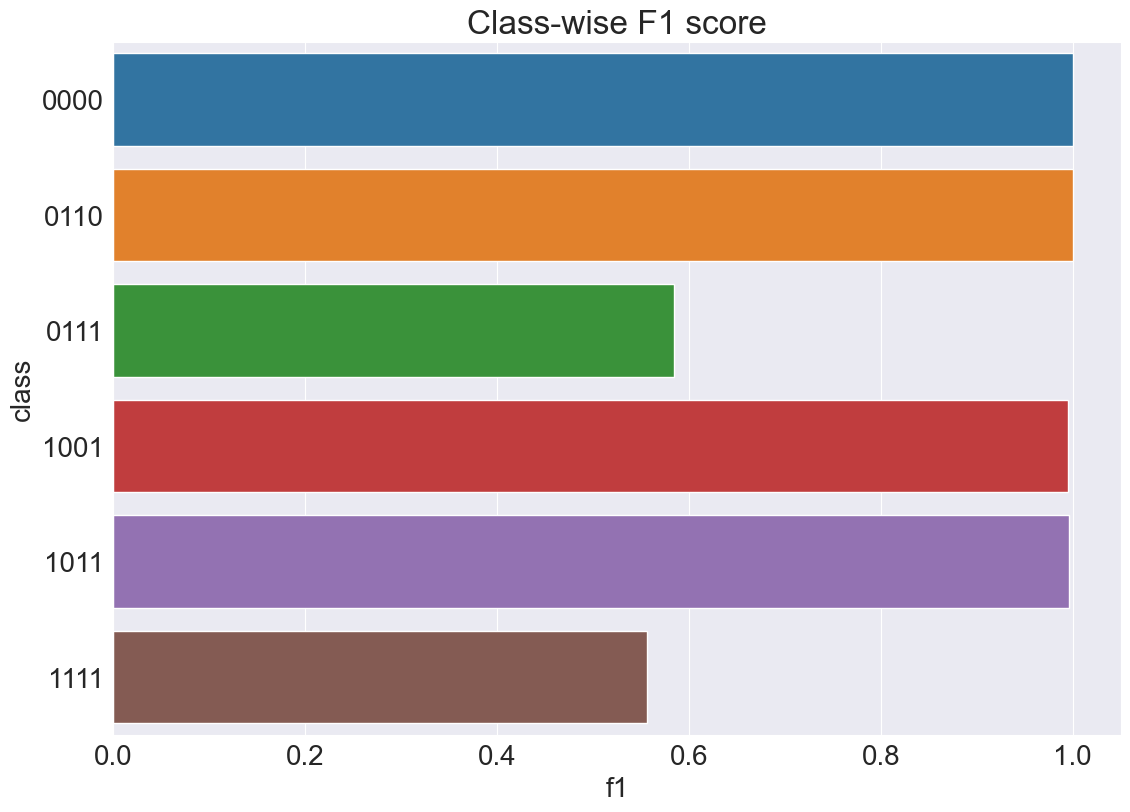

In [65]:
# Create a bar plot of class-wise F1 scores
sns.barplot(data=f1_scores_df, x='f1', y='class')

# Set the plot title
plt.title("Class-wise F1 Score")

# Display the plot
plt.show()
